# Ensemble: sithick

EC-Earth3 seems to have some issues with September sea ice thickness around edge of sea ice area:

- Seems to happen across all model variants (i.e. r3i1p1f1, r4i1p1f1, etc)
- Masking to (`siconc` != null), (`siconc` > 0) makes no difference

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'sithick'

spatial_text = 'sea-ice thickness'
spatial_units = 'm'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Thickness ({time_series_units})'
time_series_y_range = (0, 4)
time_series_y_range_full = (0, 10)
time_series_y_range_monthly = (0, 5.5)
time_series_y_range_regional = (0, 6.5)
time_series_process = lambda x: x

colormesh_kwargs = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 4.3333,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

## Time series

### Mean

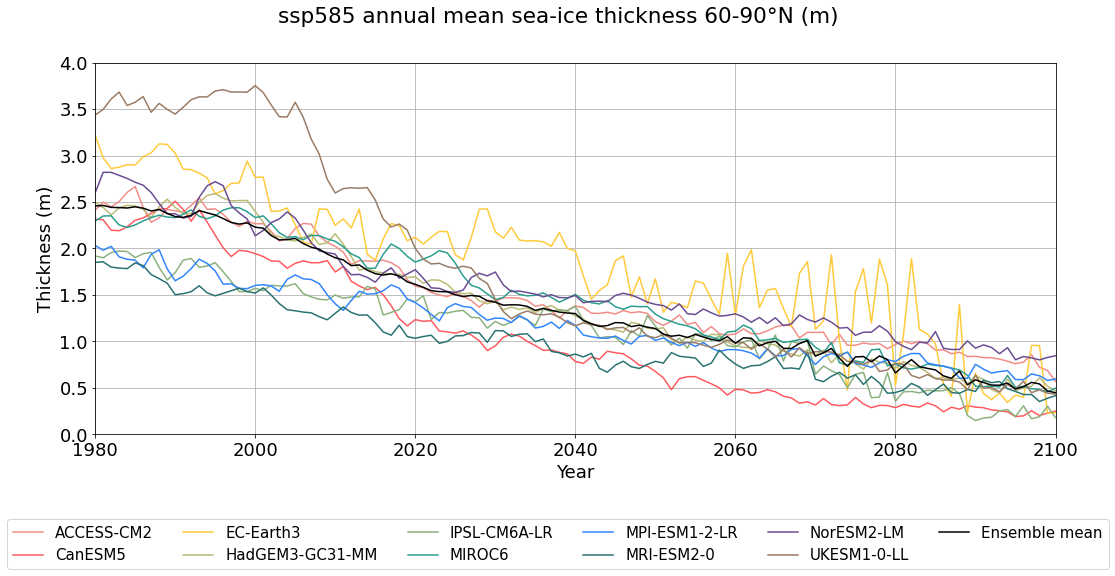

In [4]:
vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

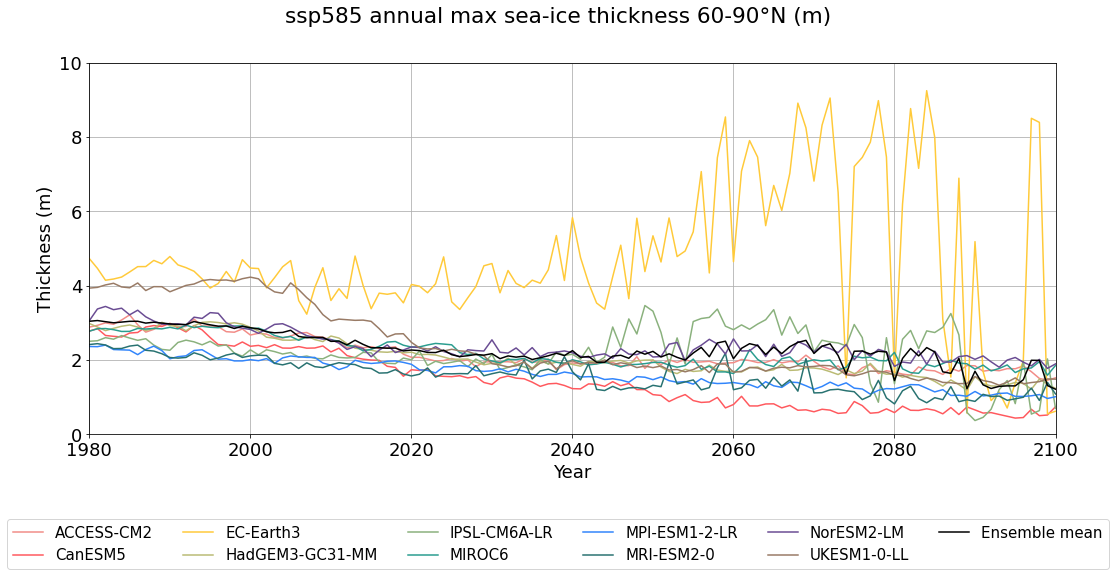

In [5]:
vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').max('time')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} annual max {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range_full
);

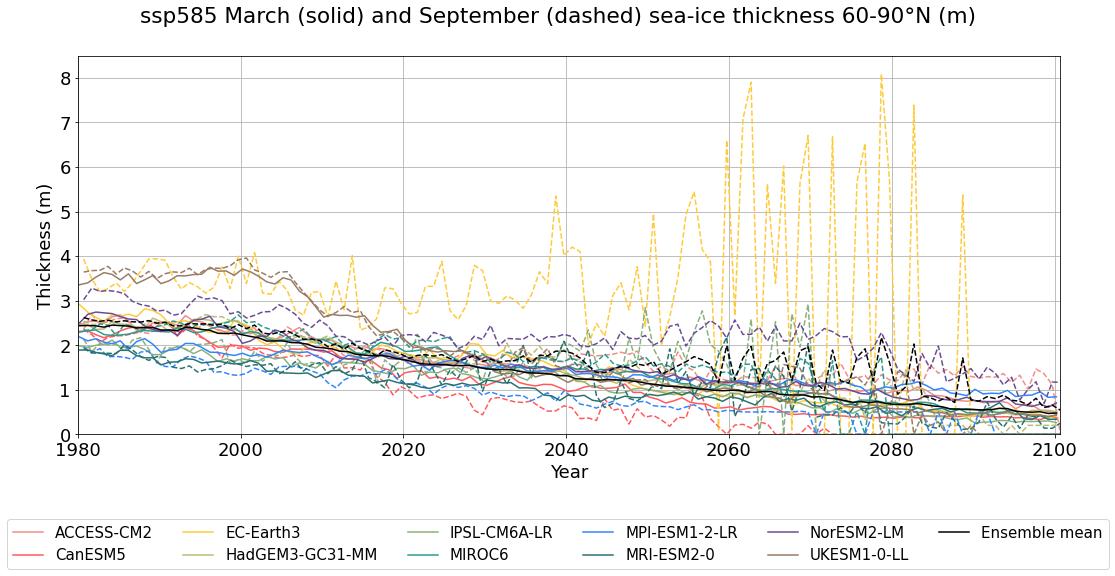

In [6]:
data_vars_mar = {}
data_vars_sep = {}

for i, item in enumerate(ensemble):
    processed_data = time_series_process(item['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    
    item_weighted_mar = processed_data.where(processed_data.time['time.month'] == 3, drop=True).weighted(weight)
    item_reduced_mar = getattr(
        item_weighted_mar, 
        time_series_weighted_method
    )(dim=item_weighted_mar.weights.dims, skipna=True)
    
    item_weighted_sep = processed_data.where(processed_data.time['time.month'] == 9, drop=True).weighted(weight)
    item_reduced_sep = getattr(
        item_weighted_sep, 
        time_series_weighted_method
    )(dim=item_weighted_sep.weights.dims, skipna=True)
    item_reduced_sep.attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    
    data_vars_mar[item['label']] = item_reduced_mar
    data_vars_sep[item['label']] = item_reduced_sep

ds_mar = xarray.Dataset(data_vars=data_vars_mar)
ds_mar = libs.ensemble.calc_variable_mean(ds_mar)
ds_mar = ds_mar.fillna(0)

ds_sep = xarray.Dataset(data_vars=data_vars_sep)
ds_sep = libs.ensemble.calc_variable_mean(ds_sep)
ds_sep['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
ds_sep = ds_sep.fillna(0)

libs.plot.time_series_from_vars(
    [
        ds_mar,
        ds_sep
    ],
    #cols=6,
    title=f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=(0, 8.5)
);

In [7]:
for obj in [{ 'arr': ds_mar, 'key': 'Thickness' }]:
    print('-----', obj['key'], '-----')
    arr = obj['arr']
    relative_arr = []
    for v in arr:
        clim_mean = float(arr[v].sel(time=slice('1980', '2010')).mean('time'))
        end_mean = float(arr[v].sel(time=slice('2080', '2100')).mean('time'))
        relative_change = (100 * end_mean / clim_mean) - 100
        relative_arr.append(relative_change)

        print(v, f'1980-2010: {clim_mean:.2f}m; 2080-2100: {end_mean:.2f}m; {relative_change:.2f}%')
        
    first_min = min(relative_arr)
    first_max = max(relative_arr)
    print('')
    print('Range', first_min, '-', first_max)
    print('Median', first_min + ((first_max - first_min) / 2))
    print('Mean', sum(relative_arr) / len(relative_arr))
    print('')
    

----- Thickness -----
ACCESS-CM2 1980-2010: 2.39m; 2080-2100: 0.77m; -68.02%
CanESM5 1980-2010: 2.13m; 2080-2100: 0.39m; -81.93%
EC-Earth3 1980-2010: 2.39m; 2080-2100: 0.52m; -78.25%
HadGEM3-GC31-MM 1980-2010: 2.38m; 2080-2100: 0.51m; -78.51%
IPSL-CM6A-LR 1980-2010: 1.79m; 2080-2100: 0.33m; -81.45%
MIROC6 1980-2010: 2.26m; 2080-2100: 0.54m; -76.02%
MPI-ESM1-2-LR 1980-2010: 1.92m; 2080-2100: 0.96m; -49.74%
MRI-ESM2-0 1980-2010: 1.62m; 2080-2100: 0.50m; -68.91%
NorESM2-LM 1980-2010: 2.36m; 2080-2100: 0.75m; -68.17%
UKESM1-0-LL 1980-2010: 3.46m; 2080-2100: 0.47m; -86.31%
Ensemble mean 1980-2010: 2.27m; 2080-2100: 0.57m; -74.68%

Range -86.31237934610007 - -49.74479064009545
Median -68.02858499309777
Mean -73.8181417122503



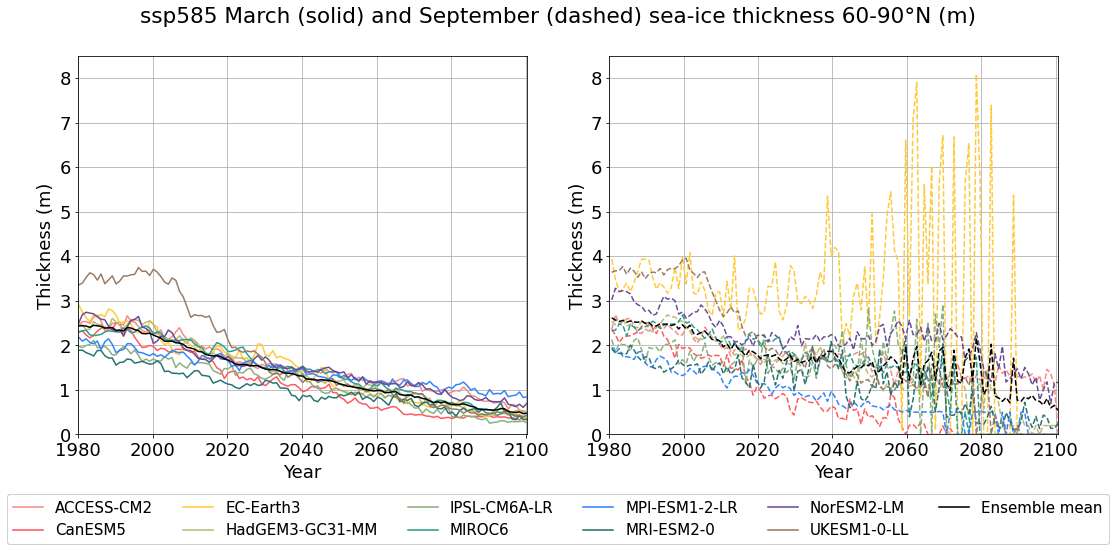

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle(f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})')

libs.plot.time_series_from_vars(
    [
        ds_mar
    ],
    #cols=6,
    ax=axes[0],
    fig=fig,
    xattr='time',
    ylabel=time_series_y_label,
    yrange=(0, 8.5)
);
libs.plot.time_series_from_vars(
    [
        ds_sep
    ],
    #cols=6,
    ax=axes[1],
    fig=fig,
    xattr='time',
    ylabel=time_series_y_label,
    yrange=(0, 8.5)
);

### Full variability

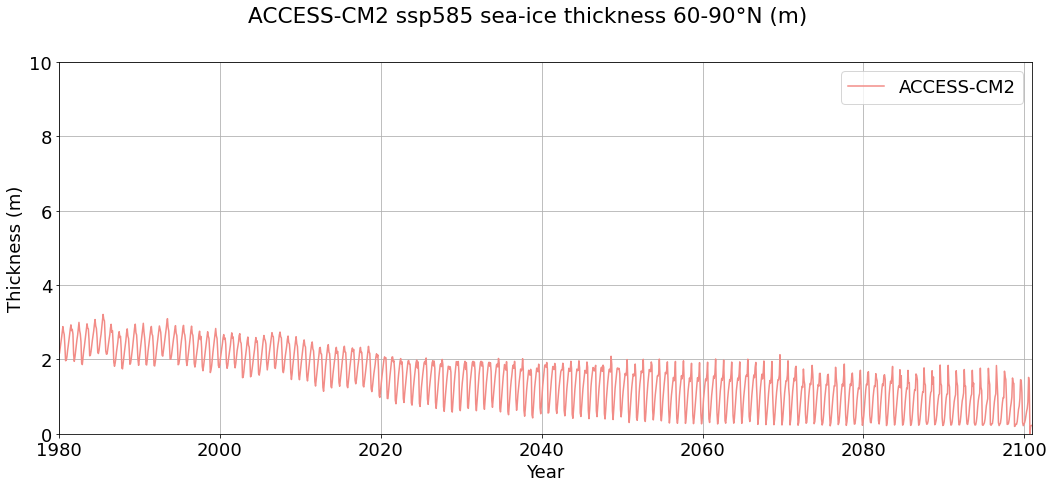

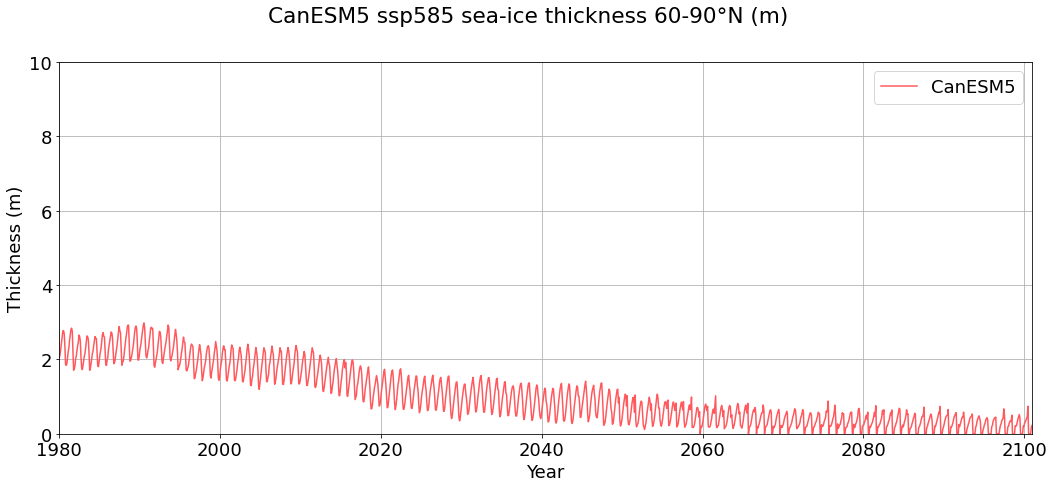

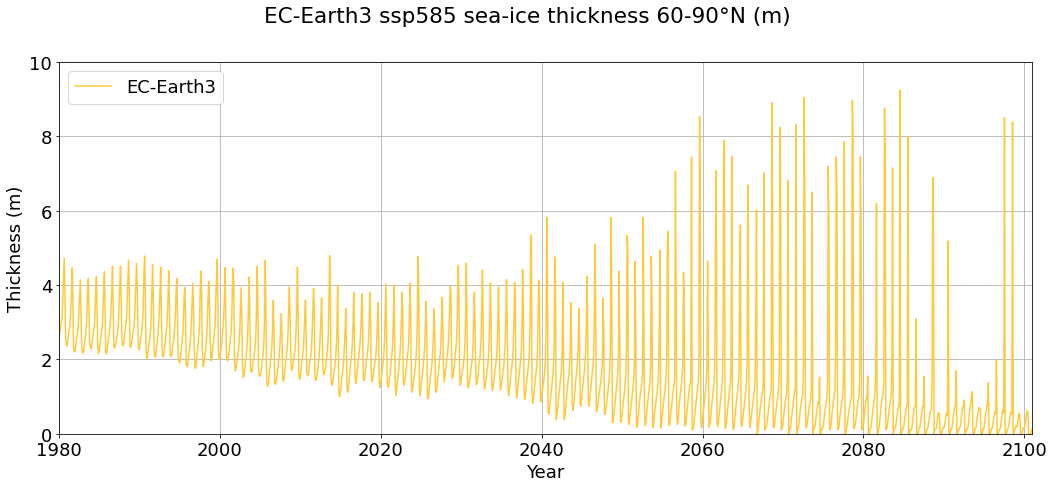

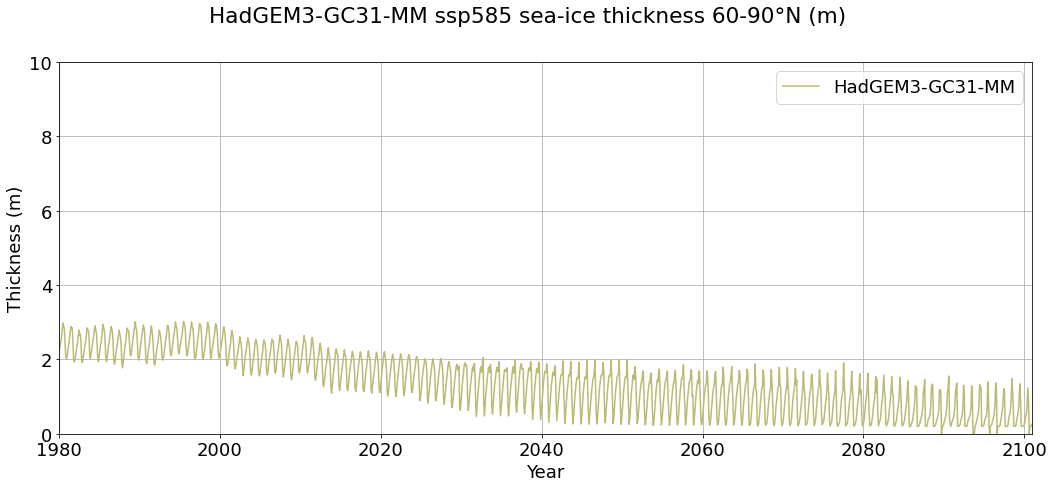

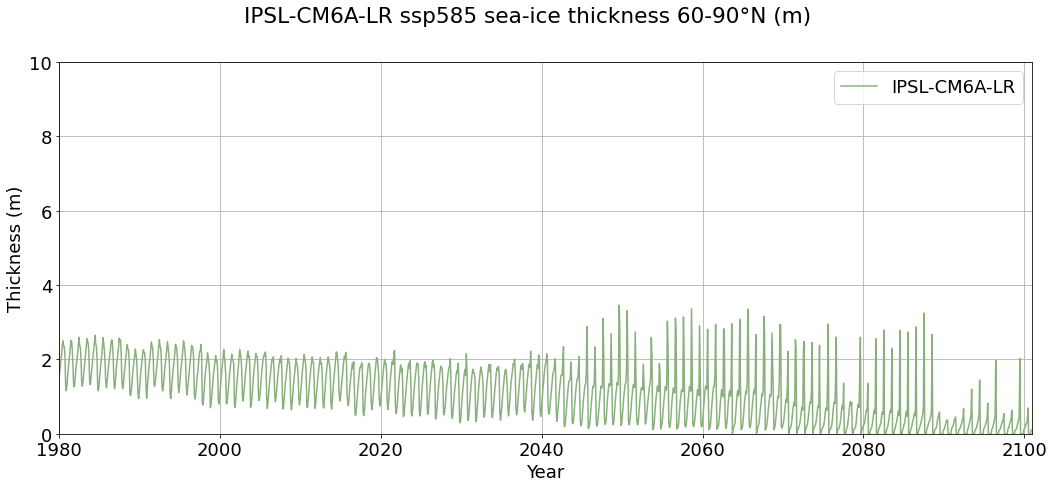

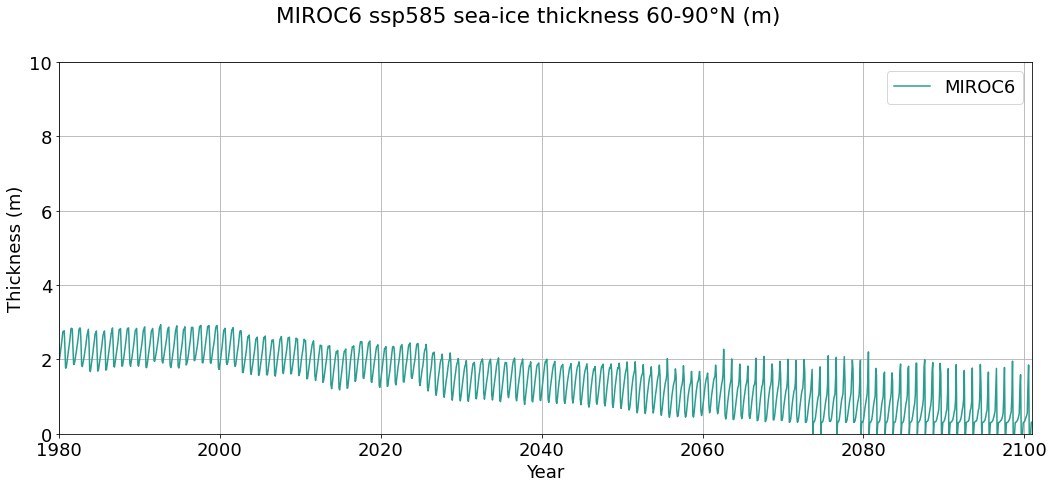

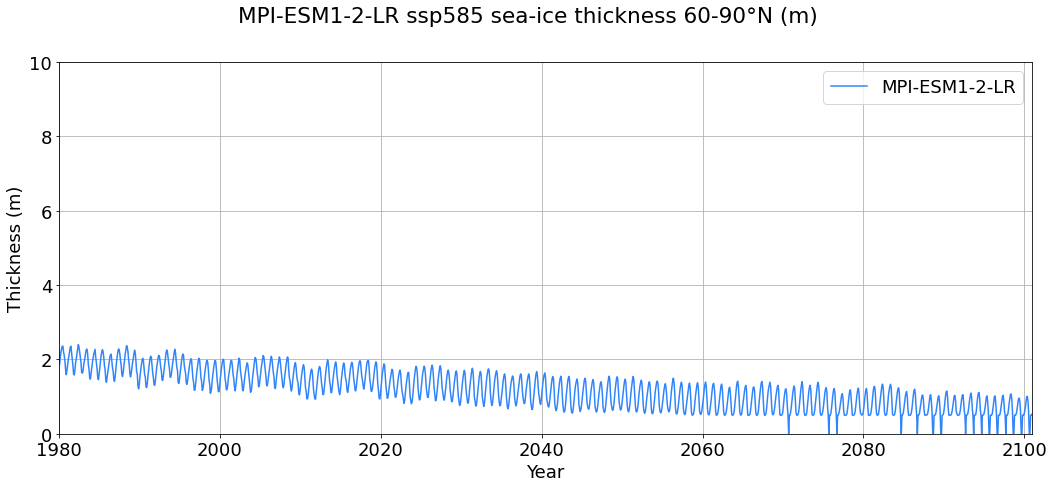

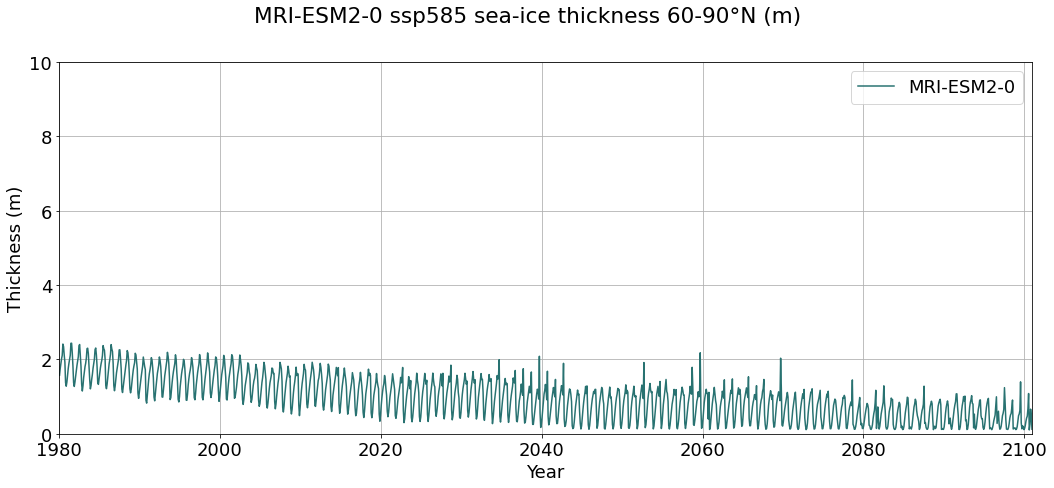

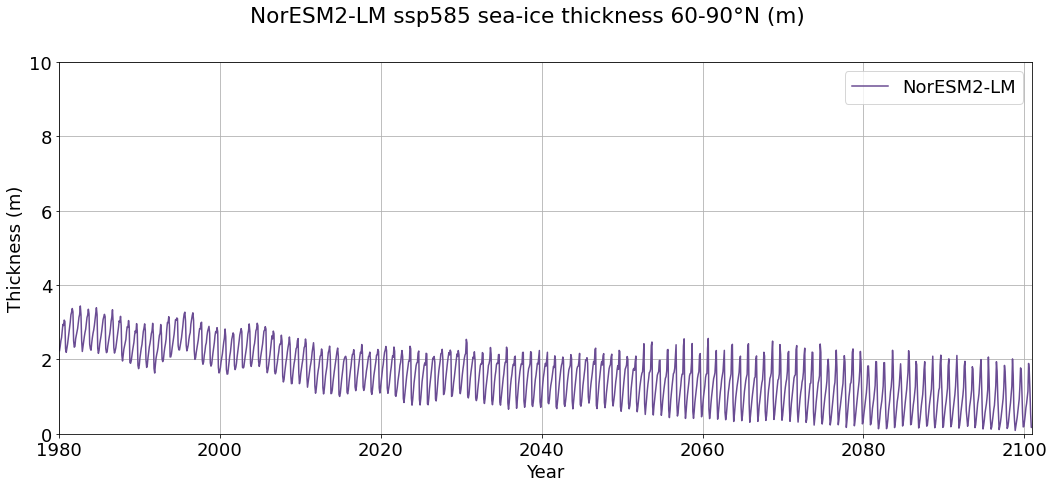

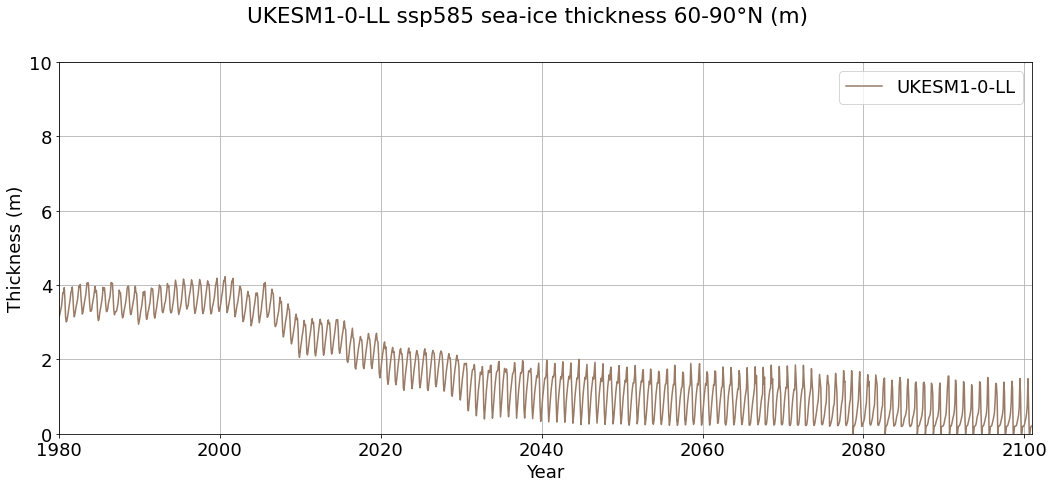

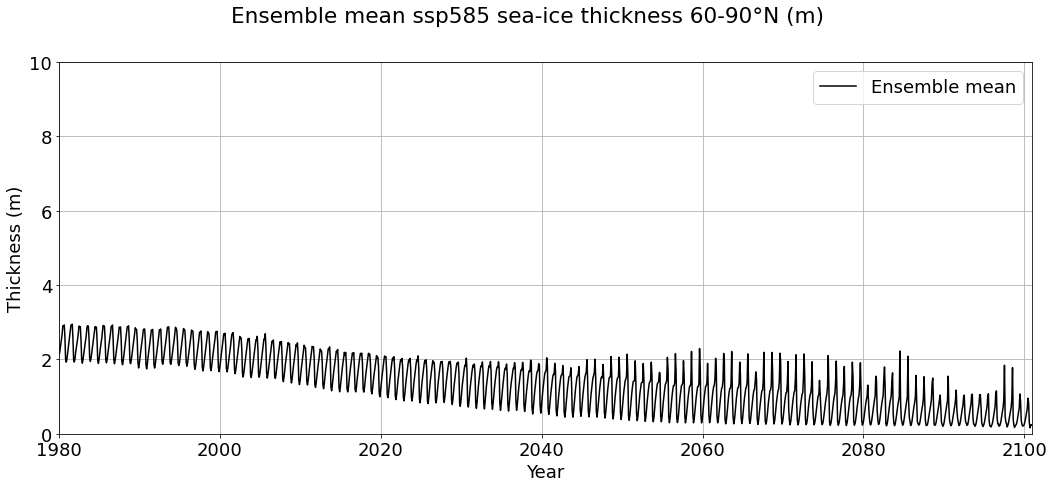

In [9]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

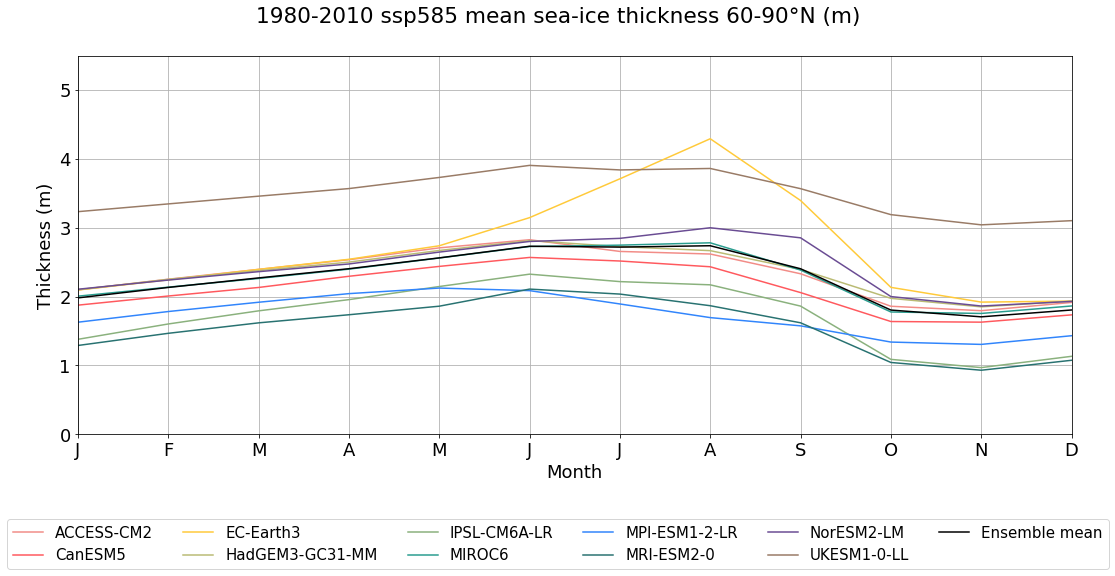

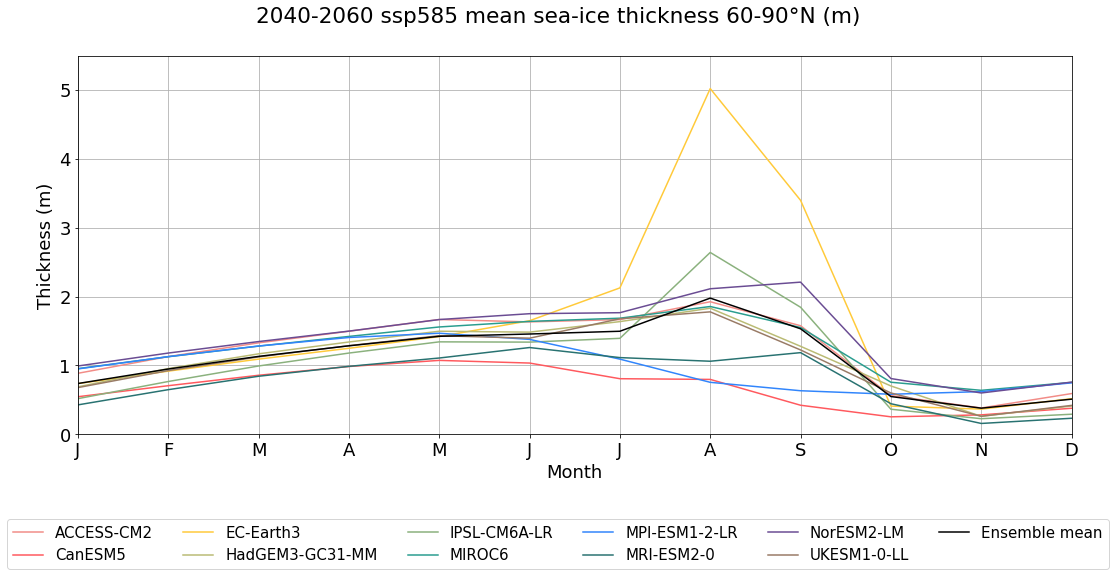

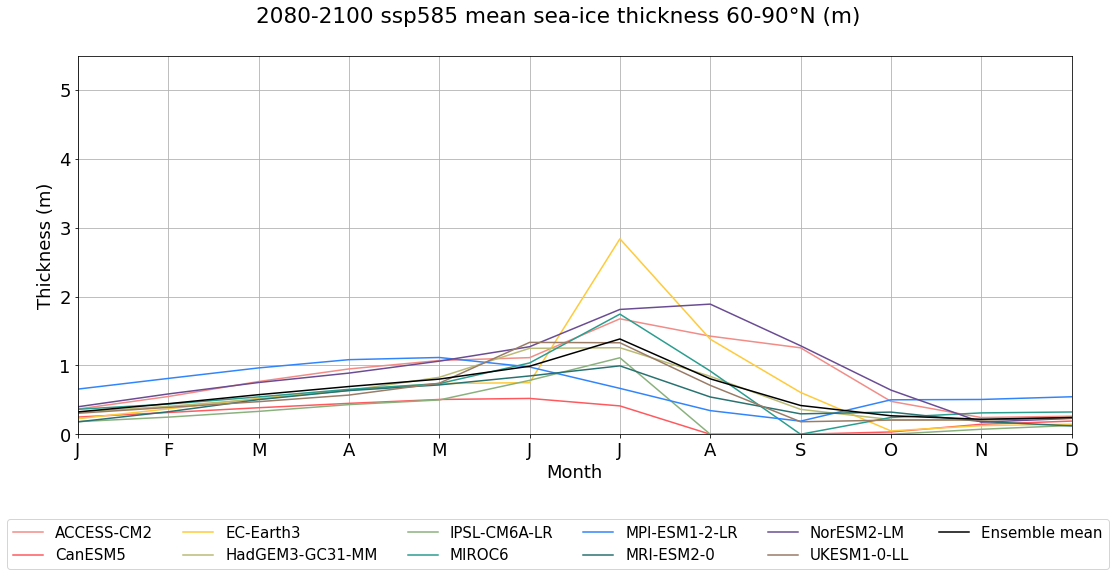

In [10]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional sea-ice thickness (time)

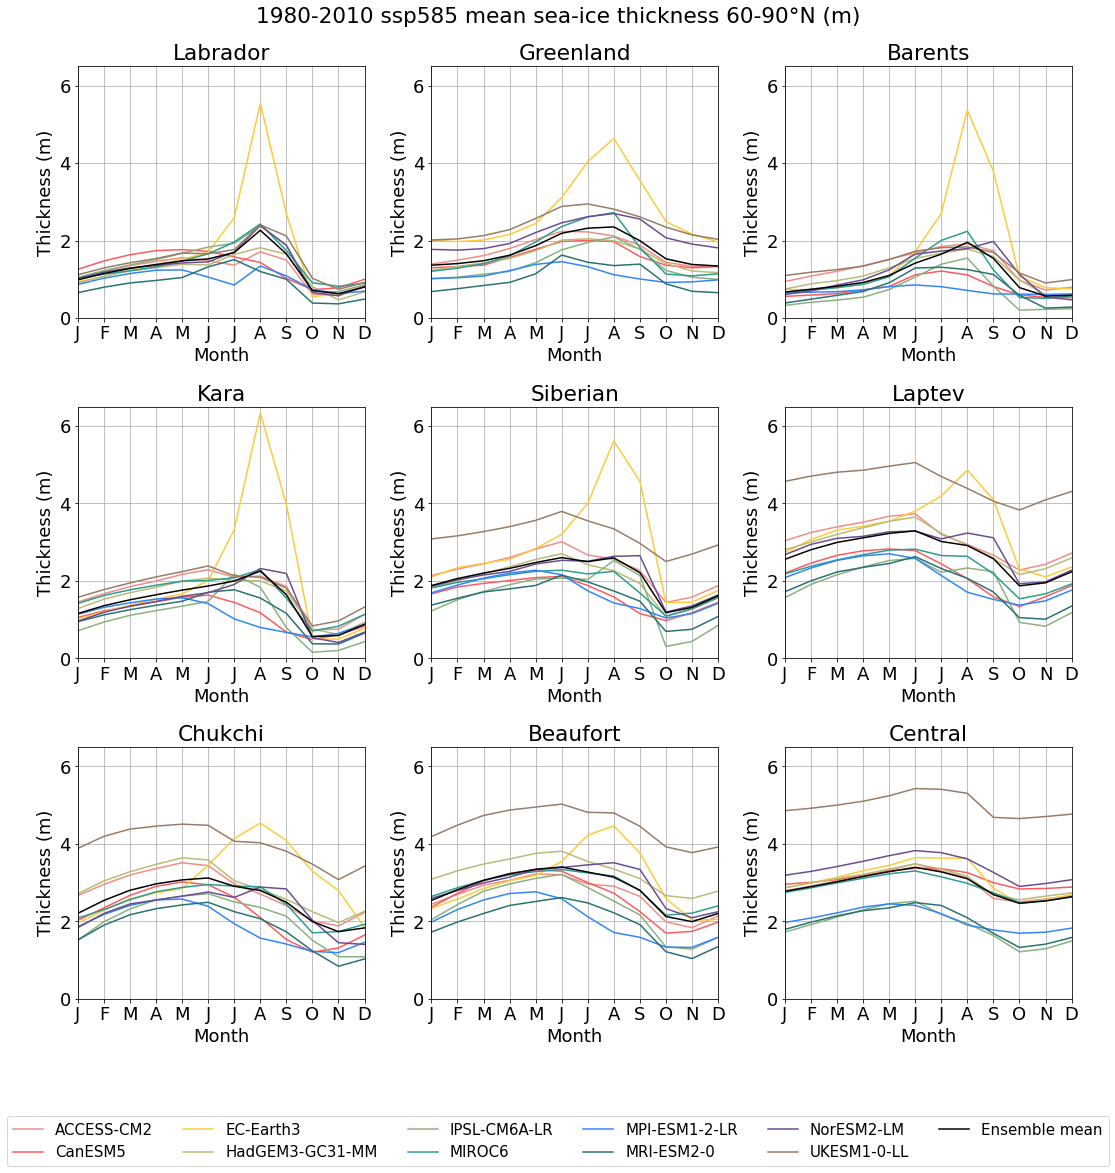

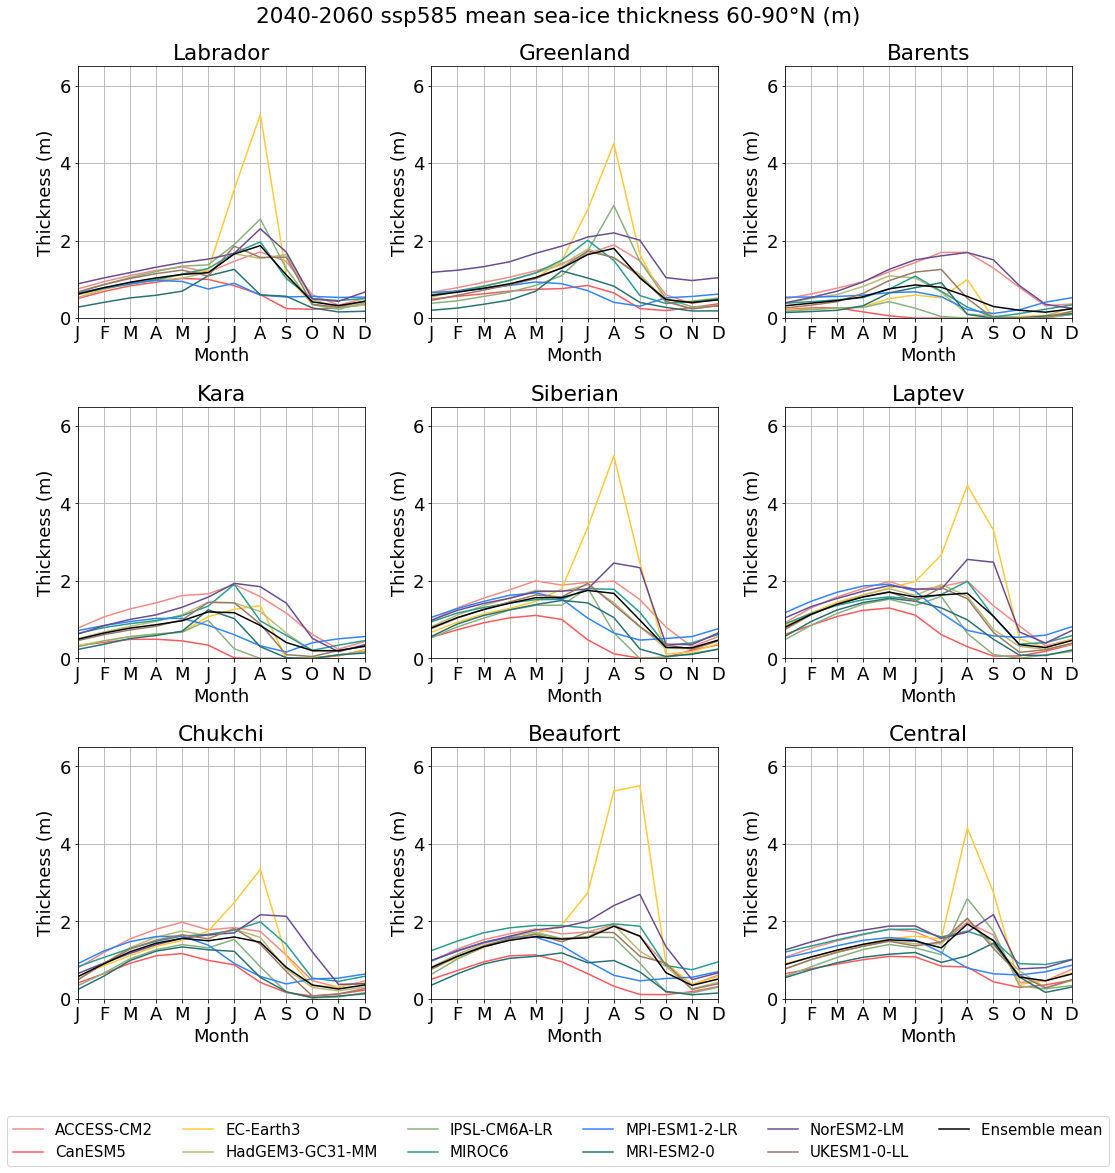

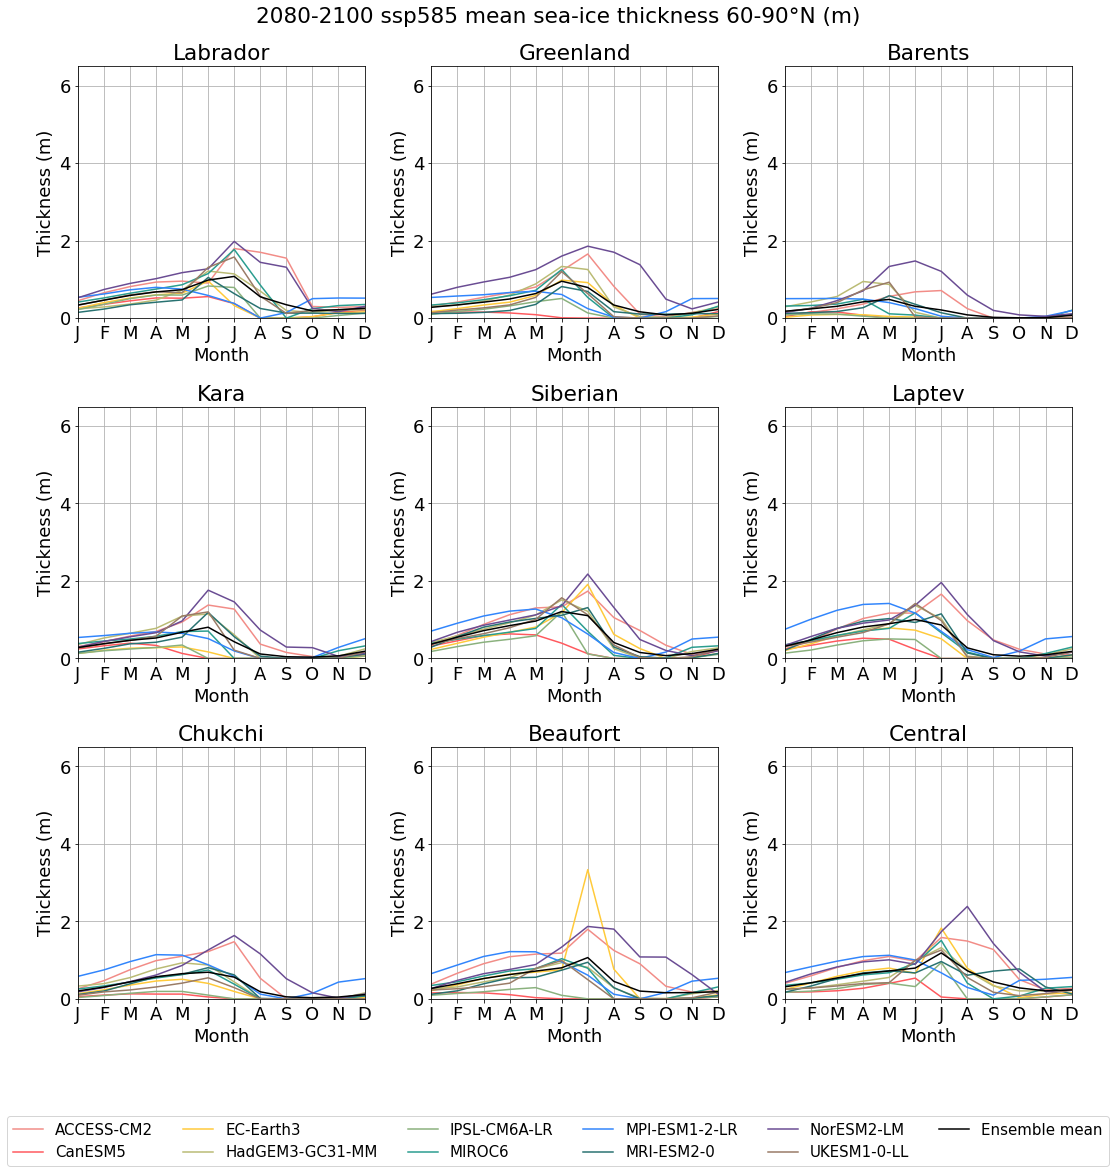

In [11]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        time_series_process(
            data.sel(**s['slice'])
        ).groupby('time.month').mean('time') for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Full region March (spatial)

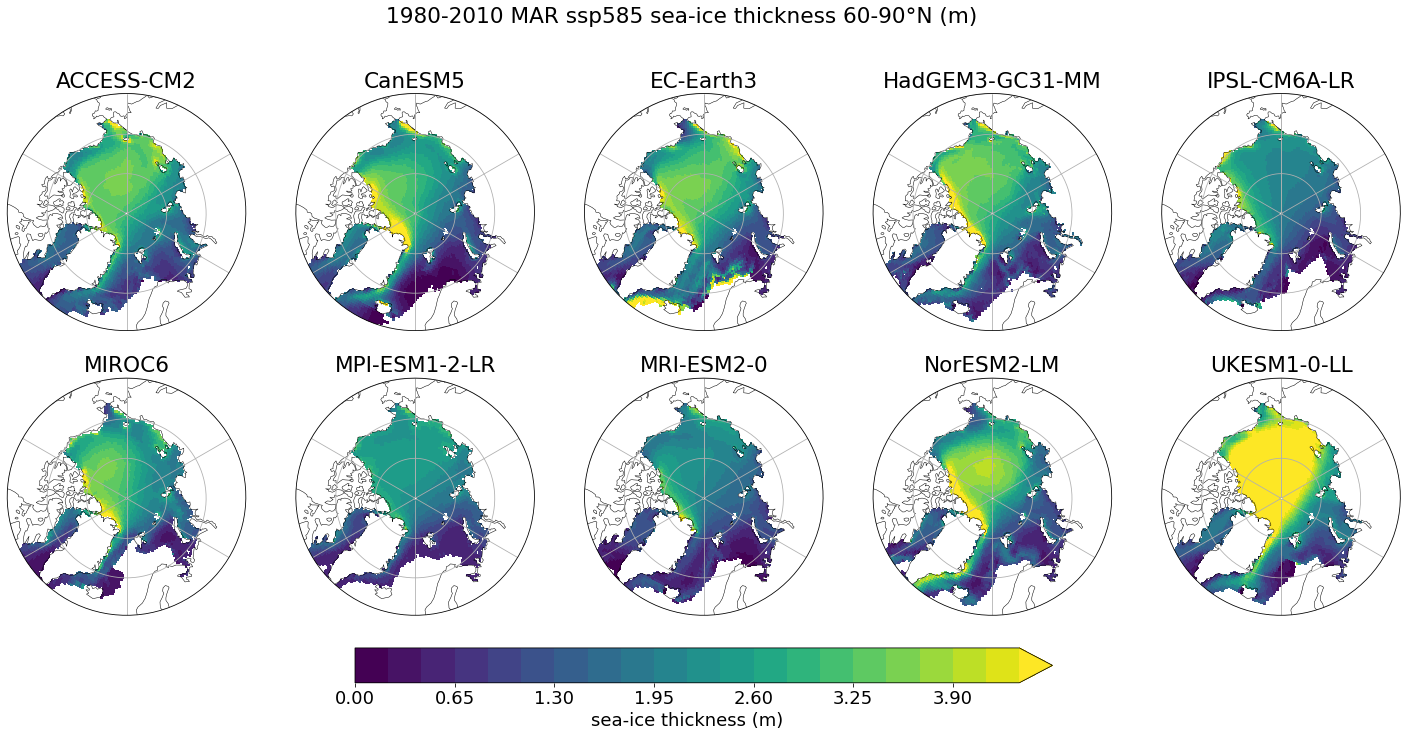

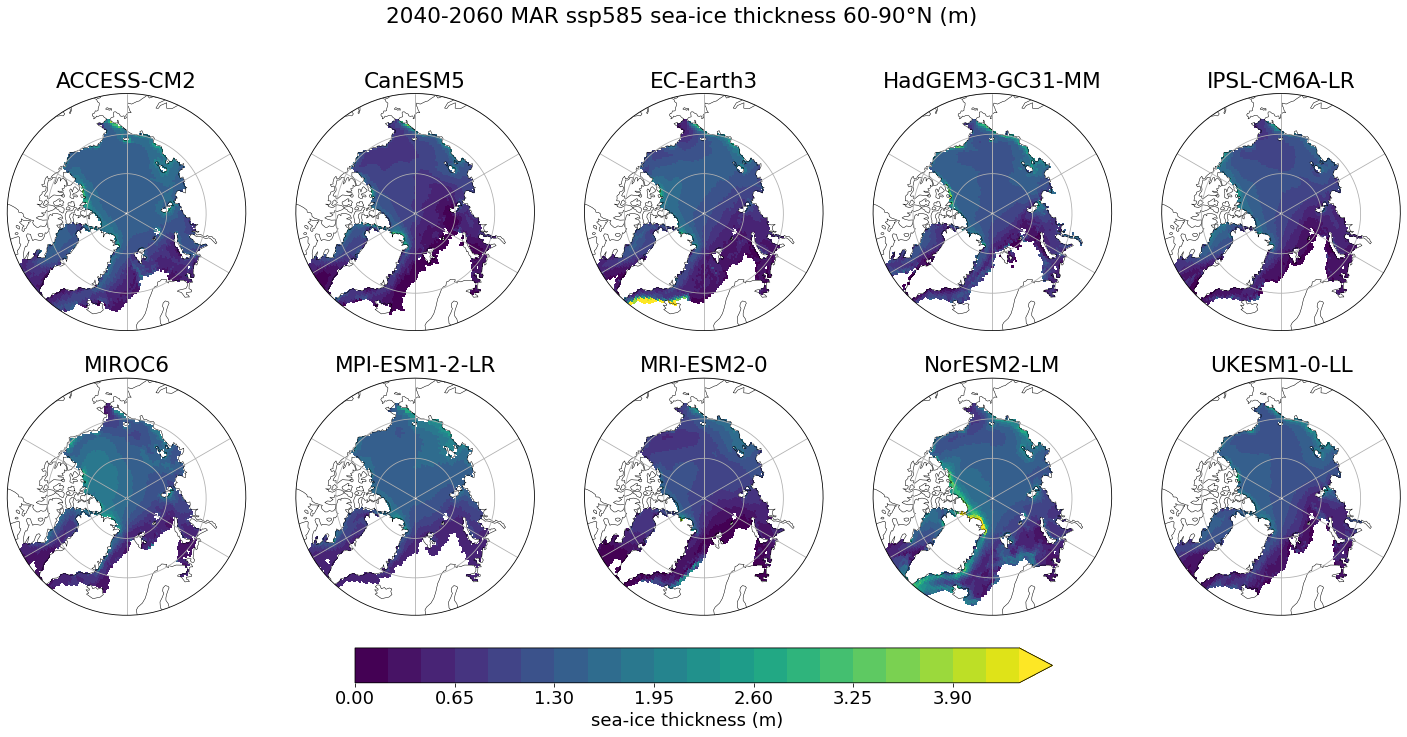

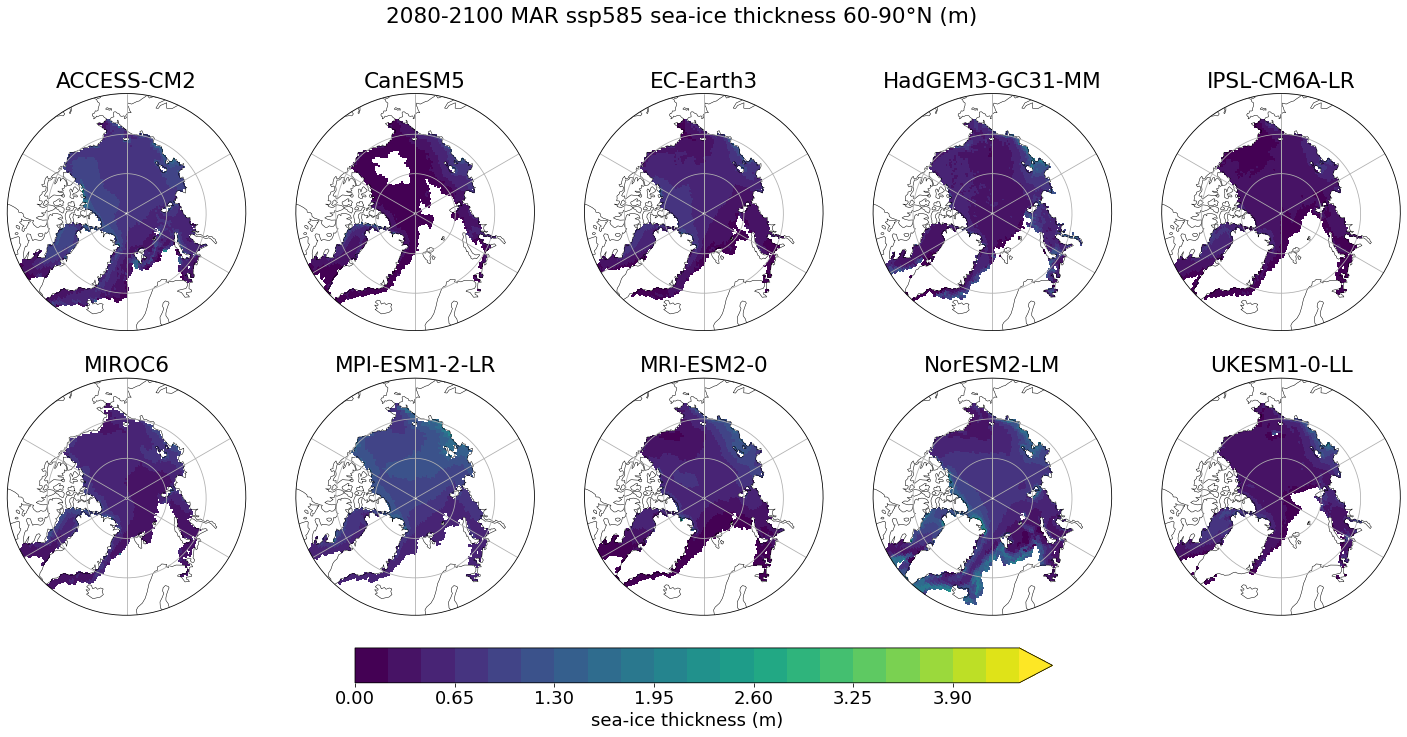

In [12]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    shape=(2, 5),
    text=spatial_text,
    time='MAR',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

### Full region September (spatial)

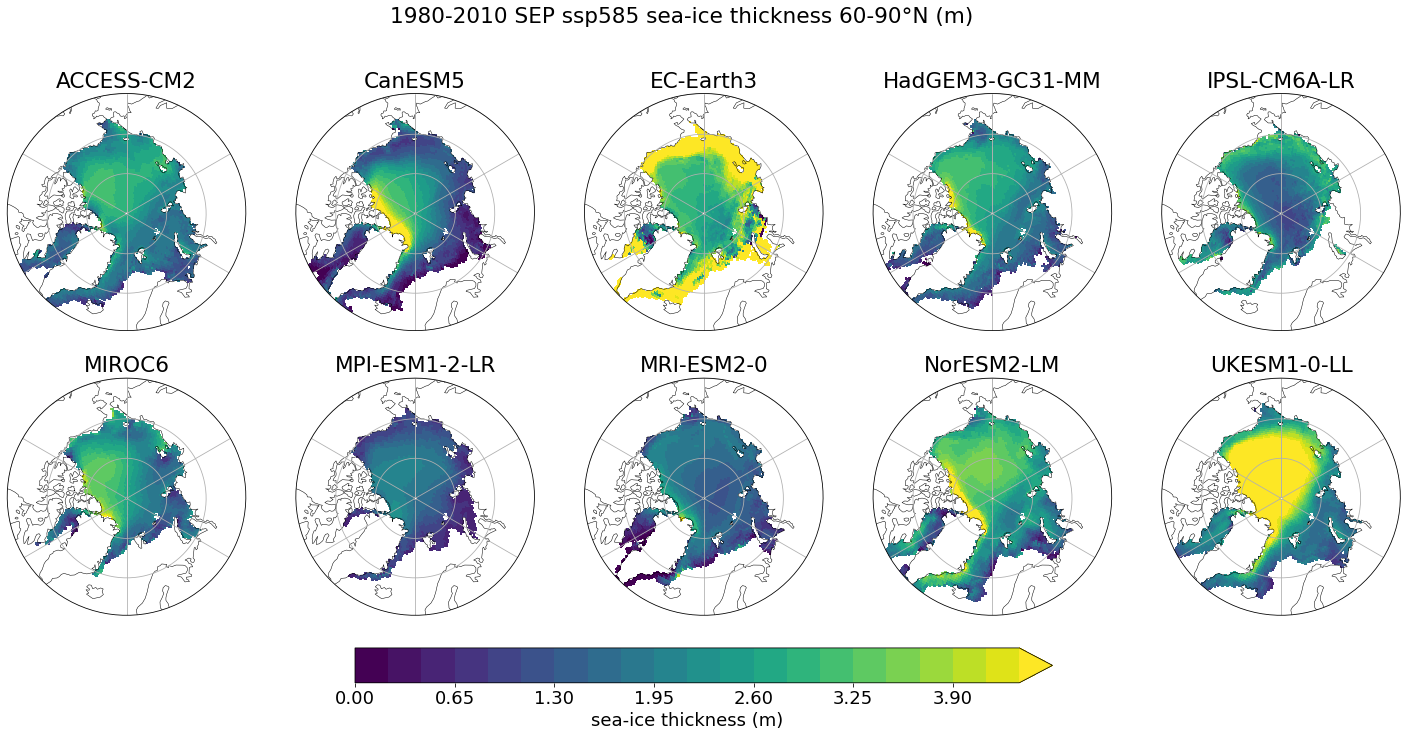

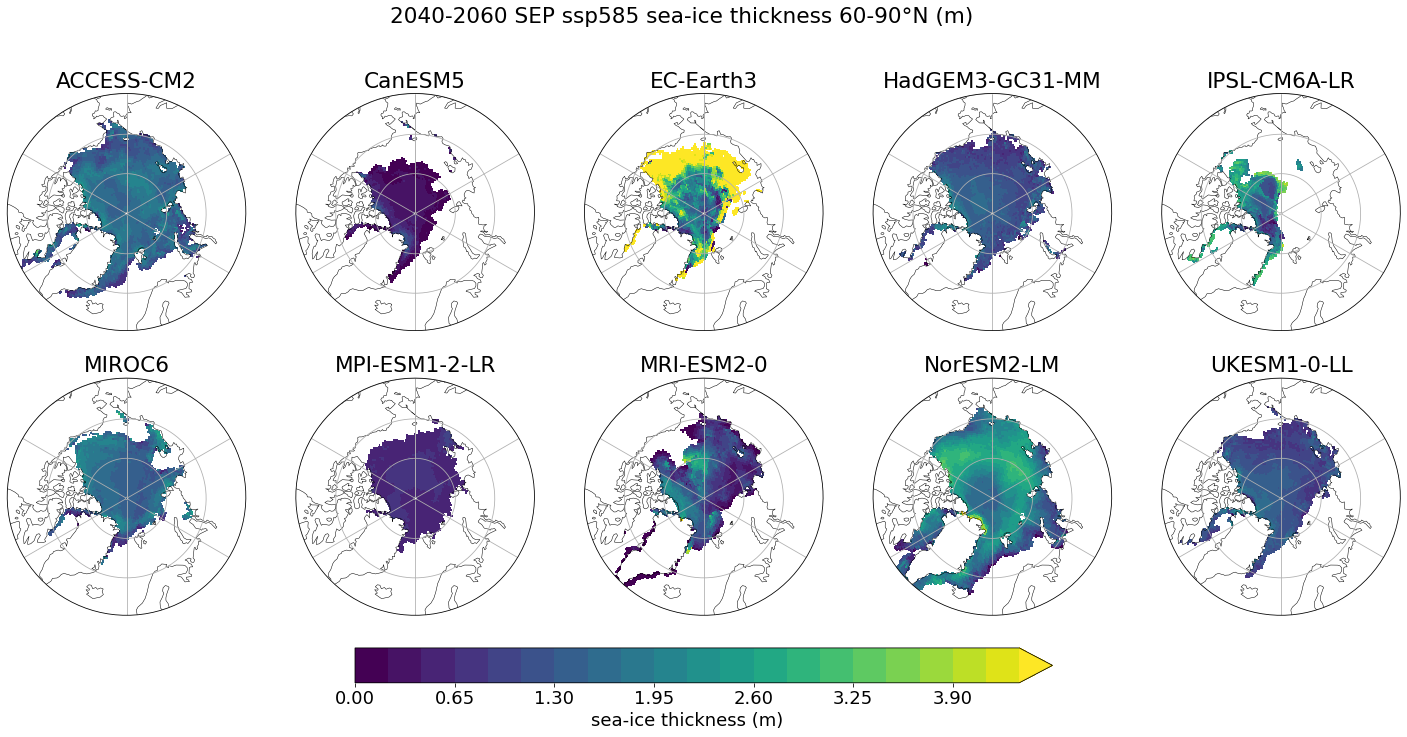

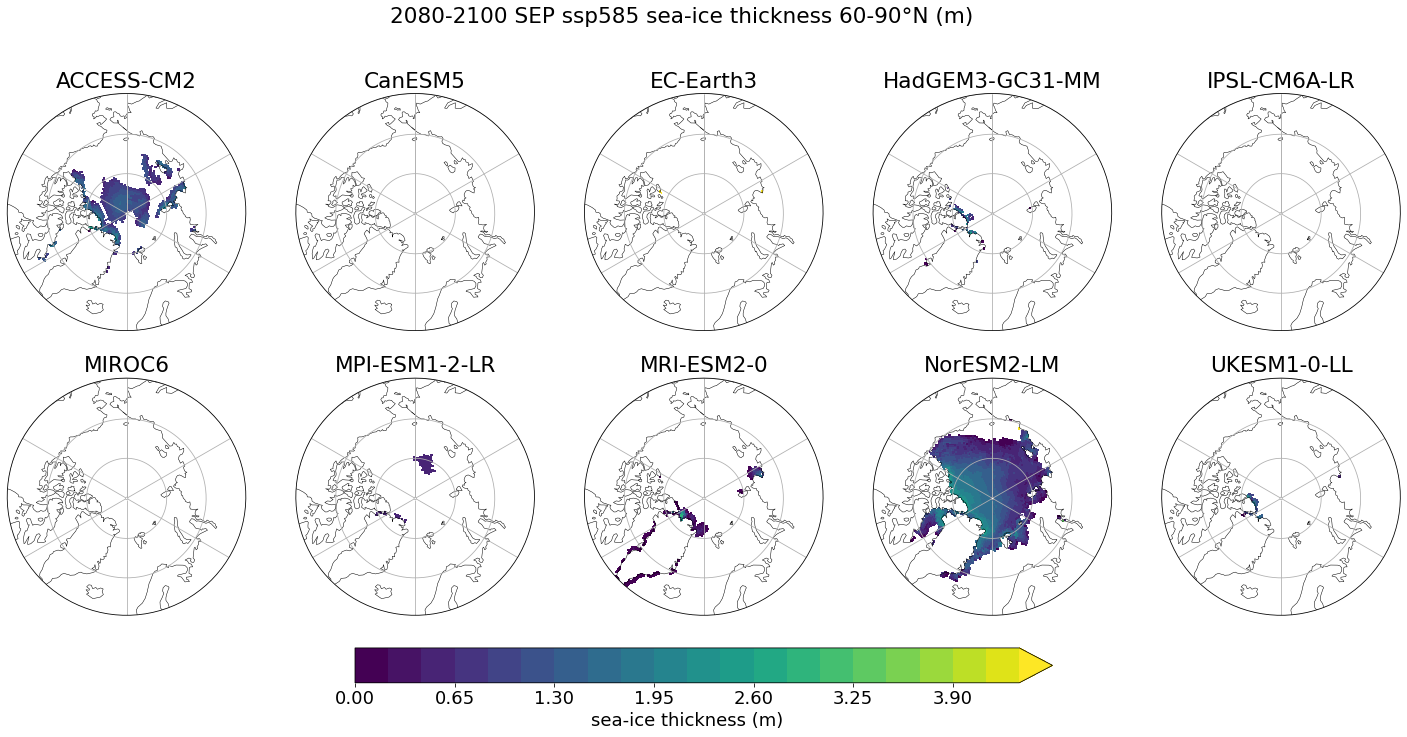

In [13]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    shape=(2, 5),
    text=spatial_text,
    time='SEP',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

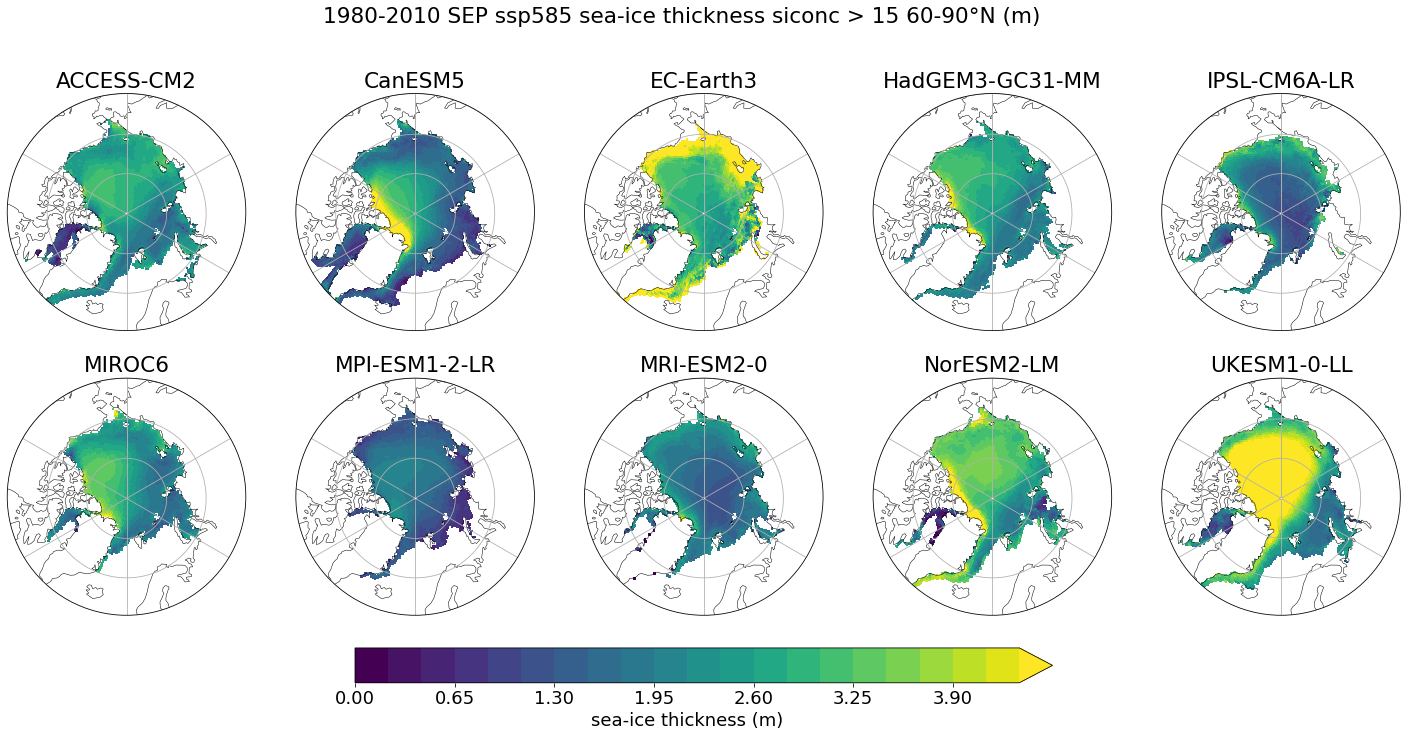

In [14]:
ensemble_siconc, weight_siconc = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    'siconc'
)
for i, item in enumerate(ensemble):
    ensemble[i]['data'] = item['data'].where(ensemble_siconc[i]['data'] > 15)

ensemble_time_slices = libs.analysis.generate_slices(ensemble)

libs.plot.calendar_division_spatial(
    [ensemble_time_slices[0]], 
    colormesh_kwargs=colormesh_kwargs,
    shape=(2, 5),
    text=spatial_text,
    time='SEP',
    title='{label} {time} ssp585 {text} siconc > 15 60-90°N ({units})',
    units=spatial_units
)